In [ ]:
import matplotlib
import pandas as pd
import csv
import numpy as np
%matplotlib inline 

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

In [4]:
train = pd.read_csv("data/3Classes_train.csv", sep="\t")
test = pd.read_csv("data/3Classes_test.csv", sep="\t")

y_train = train["Global classifier2"]
y_test = test["Global classifier2"]

x_train = train["Sequence"].copy()
x_test = test["Sequence"].copy()

In [6]:
max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
batch_size = 32

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

4446 train sequences
1112 test sequences


In [8]:
def end_adder(X):
    for s in range(len(X)):
        X.loc[s] += '*'
    return X

x_train = end_adder(x_train)
x_test = end_adder(x_test)

In [10]:
max_len = len(max(x_train, key=len))
print(max_len)

1501


In [11]:
# all amino acids (in blosum order)
aa = "ARNDCQEGHILKMFPSTWYVU*"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [12]:
cat = ['Mostly Cytosolic', 'Mostly Nuclear', 'Mostly Organellar']

tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [15]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

y_train_indices = cat_to_indices(y_train)
y_test_indices = cat_to_indices(y_test)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [16]:
# Function to convert sequences to array of indices. I will that that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    """
    Converts an array of senquences (strings) into an array of indices corresponding to aa in the sequence.
    
    Arguments:
    X -- array of sequences (strings), of shape (m, 1)
    aa_to_int -- a dictionary containing the each aa mapped to its index
    max_len -- maximum lengh of sequences array, bigger than test set 
    
    Returns:
    X_indices -- array of indices corresponding to aa in the sequences from X, of shape (m, max_len), padded
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros([m,max_len])
    X_indices.fill(aa_to_int["*"])
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = aa_to_int[seq_aa[w]]
            # Increment j to j + 1
            j = j+1
            
    ### END CODE HERE ###
    
    return X_indices

x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)

In [20]:
print('Pad sequences (samples x time)')
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len)
print('x_train shape:', x_train_pad.shape)
print('x_test shape:', x_test_pad.shape)

Pad sequences (samples x time)
x_train shape: (4446, 1501)
x_test shape: (1112, 1501)


In [18]:
x_test_indices.shape

(1112, 1501)

In [35]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train_pad, y_train_OH,
          batch_size=batch_size,
          epochs=50,
          validation_data=[x_test_pad, y_test_OH])

Train...
Train on 4446 samples, validate on 1112 samples
Epoch 1/50
4446/4446 [==============================] - 266s 60ms/step - loss: 0.9427 - accuracy: 0.5232 - val_loss: 0.8637 - val_accuracy: 0.5836
Epoch 2/50
4446/4446 [==============================] - 259s 58ms/step - loss: 0.8527 - accuracy: 0.6046 - val_loss: 0.8477 - val_accuracy: 0.5989
Epoch 3/50
4446/4446 [==============================] - 257s 58ms/step - loss: 0.8343 - accuracy: 0.6230 - val_loss: 1.1764 - val_accuracy: 0.3705
Epoch 4/50
4446/4446 [==============================] - 256s 58ms/step - loss: 0.9260 - accuracy: 0.5367 - val_loss: 0.8198 - val_accuracy: 0.6088
Epoch 5/50
4446/4446 [==============================] - 259s 58ms/step - loss: 0.7910 - accuracy: 0.6395 - val_loss: 0.7747 - val_accuracy: 0.6394
Epoch 6/50
4446/4446 [==============================] - 256s 58ms/step - loss: 0.8100 - accuracy: 0.6300 - val_loss: 0.8225 - val_accuracy: 0.6214
Epoch 7/50
4446/4446 [==============================] - 256s 

In [36]:
model.save("3Classes_model2.h5")

In [37]:
y_pred = model.predict(x_test_indices)
y_pred

array([[0.02036941, 0.01440075, 0.7639283 ],
       [0.00586838, 0.00649083, 0.91288924],
       [0.7473827 , 0.10872462, 0.17654604],
       ...,
       [0.8635169 , 0.17750296, 0.13816524],
       [0.0080651 , 0.00232333, 0.8581438 ],
       [0.01101428, 0.03040522, 0.8319907 ]], dtype=float32)

In [38]:
y_test_OH

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [39]:
# One hot to label 
#Y is list of OH vector

def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

y_pred_indices = OH_to_label_indices(y_pred)

In [40]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

y_pred_cat = indices_to_cat(y_pred_indices)

In [41]:
y_pred_cat

['Mostly Organellar',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Organellar',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Nuclear',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Organellar',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Cytosolic',
 'Mostly Organellar',
 'Mostly Cytosolic'

In [52]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test_indices, y_pred_indices)
conf_mx

array([[369,   3,  12],
       [184,   6,  11],
       [136,   7, 384]])

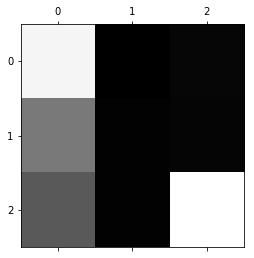

In [53]:
import matplotlib.pyplot as plt

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# That's really odd, seems it cannot recognize nuclear compartment 

In [50]:
cat

['Mostly Cytosolic', 'Mostly Nuclear', 'Mostly Organellar']

In [51]:
model2 = Sequential()
model2.add(Embedding(max_features, 192, input_length=max_len))
model2.add(Bidirectional(LSTM(192)))
model2.add(Dropout(0.2))
model2.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model2.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])

print('Train...')
model2.fit(x_train_pad, y_train_OH,
          batch_size=batch_size,
          epochs=10,
          validation_data=[x_test_pad, y_test_OH])

Train...
Train on 4446 samples, validate on 1112 samples
Epoch 1/10
4446/4446 [==============================] - 602s 135ms/step - loss: 0.9879 - accuracy: 0.5162 - val_loss: 0.9287 - val_accuracy: 0.5638
Epoch 2/10
4446/4446 [==============================] - 602s 135ms/step - loss: 0.9033 - accuracy: 0.5661 - val_loss: 0.8672 - val_accuracy: 0.6115
Epoch 3/10
4446/4446 [==============================] - 593s 133ms/step - loss: 0.8346 - accuracy: 0.6199 - val_loss: 0.7958 - val_accuracy: 0.6394
Epoch 4/10
4446/4446 [==============================] - 587s 132ms/step - loss: 0.8319 - accuracy: 0.6257 - val_loss: 0.7762 - val_accuracy: 0.6304
Epoch 5/10
4446/4446 [==============================] - 584s 131ms/step - loss: 0.7649 - accuracy: 0.6480 - val_loss: 0.7237 - val_accuracy: 0.6673
Epoch 6/10
4446/4446 [==============================] - 589s 133ms/step - loss: 0.7975 - accuracy: 0.6300 - val_loss: 0.8715 - val_accuracy: 0.5953
Epoch 7/10
4446/4446 [==============================] -

In [65]:
model2.save("3Classes_model3.h5")

In [54]:
y_pred2 = model2.predict(x_test_indices)
y_pred2

array([[0.01793272, 0.0089309 , 0.9731364 ],
       [0.00866692, 0.00539388, 0.98593915],
       [0.5470672 , 0.17994563, 0.27298716],
       ...,
       [0.5351773 , 0.28138697, 0.18343566],
       [0.00954634, 0.00613804, 0.9843156 ],
       [0.01238737, 0.00806033, 0.9795523 ]], dtype=float32)

In [62]:
y_pred2_indices = OH_to_label_indices(y_pred2)

In [63]:
conf_mx = confusion_matrix(y_test_indices, y_pred2_indices)
conf_mx

array([[313,  21,  50],
       [144,  37,  20],
       [102,  15, 410]])

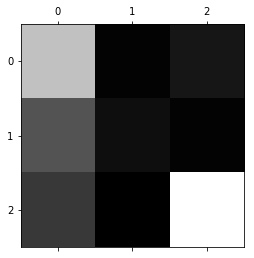

In [64]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# A bit better but problem to identify nuclear proteins 
# But better after 10 epochs!!!

In [66]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

In [ ]:
model2 = Sequential()
model2.add(Embedding(max_features, 192, input_length=max_len))
model2.add(Bidirectional(LSTM(192)))
model2.add(Dropout(0.2))
model2.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model2.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])

print('Train...')
model2.fit(x_train_pad, y_train_OH,
          batch_size=batch_size,
          epochs=10,
           class_weight= class_weights,            
          validation_data=[x_test_pad, y_test_OH])

Train...
Train on 4446 samples, validate on 1112 samples
Epoch 1/10
4446/4446 [==============================] - 958s 215ms/step - loss: 1.0259 - accuracy: 0.4962 - val_loss: 0.9862 - val_accuracy: 0.5216
Epoch 2/10
4446/4446 [==============================] - 943s 212ms/step - loss: 0.8623 - accuracy: 0.5985 - val_loss: 0.7659 - val_accuracy: 0.6556
Epoch 3/10
4446/4446 [==============================] - 933s 210ms/step - loss: 0.7445 - accuracy: 0.6712 - val_loss: 0.7056 - val_accuracy: 0.6817
Epoch 4/10
2688/4446 [=================>............] - ETA: 5:45 - loss: 0.8988 - accuracy: 0.5792